In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display as dsp
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from scipy import stats
#TODO: Change focus from authorship to quality / price

In [2]:
#Where 'model' refers to decomposition model used for topic extraction
#'vectorizer' refers to the model used to vectorize our linguistic data

def get_top_words(model, vectorizer, n_top_words = 10):
    
    #Pull feature names from vectorizer
    feature_names = vectorizer.get_feature_names()
    
    #Return top 'n' words
    for topic_id, topic in enumerate(model.components_):
        print('Topic: {} | {}'.format(topic_id, [feature_names[i] for i in topic.argsort()[:-n_top_words - 1: -1]]))
        
#Clean Text
def text_cleaner(text):
    
    #Start by ensuring all excess whitespace is eliminated
    text = ' '.join(text.split())
    
    return text

In [ ]:
#Instantiate our tf-idf model
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Instantiate truncated SVD for dimensionality reduction and create normalized pipeline
svd = TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy = False))

Data taken from kaggle
https://www.kaggle.com/zynicide/wine-reviews

# The Wine Review List

What we have here is a dataset of wine reviews from the Wine Enthusiast magazine (https://www.winemag.com/?s=&drink_type=wine). This dataset has gained popularity as a training set to measure the capabilities of various classifiers, clustering algorithms and natural language processing models.

There are several reasons why this dataset is so good for testing machine learning processes. First, the immense size of the dataset (at over 100'000 entries, each with a paragraph of text written by dozens of unique authors, with several other unique attributes such as title of the wine, type of wine, country of origin et al.

There are dozens of potential projects, such as supervised learning techniques involving predicting the authorship of the wine review based on the metrics of the review itself, or unsupervised techniques such as clustering reviews and wine types.

## The Data

We will first explore the form our data takes. We import the data as a pandas dataframe from a CSV file. There are several potential projects we could do using only a handful of columns from the original dataset, and thankfully, not very many entries countained null values we had to get rid of.

We will start by exploring a subset of the columns available from the raw dataset, being: 'description', 'title', 'country', 'taster_name', and 'variety'.

In [3]:
raw = pd.read_csv('wine-reviews/winemag-data-130k-v2.csv')
print('The raw dataset has {} columns.'.format(len(raw.columns)))
print(raw.columns)

#print((raw['points'].unique()))
#dsp(raw.head())

data = raw[['description', 'points', 'price', 'title', 'country', 'taster_name', 'variety']]
data.dropna(inplace = True)

print("Original dataframe shape:{}".format(raw.shape))
print("Final data shape:{}".format(data.shape))

dsp(data.head())
print(len(data.variety.unique()))


#Clean text
data['description'] = data['description'].apply(lambda x: text_cleaner(x))

#Group reviewer-variety pairs

#Compare how similar reviewers are within each variety

#Use clustering to group varieties of wine into categories and
#compare similarities and differences between authors' descriptions
#within these.

The raw dataset has 14 columns.
Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')
Original dataframe shape:(129971, 14)
Final data shape:(96420, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,description,points,price,title,country,taster_name,variety
1,"This is ripe and fruity, a wine that is smooth...",87,15.0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portugal,Roger Voss,Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),US,Paul Gregutt,Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,US,Alexander Peartree,Riesling
4,"Much like the regular bottling from 2012, this...",87,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,US,Paul Gregutt,Pinot Noir
5,Blackberry and raspberry aromas show a typical...,87,15.0,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Spain,Michael Schachner,Tempranillo-Merlot


653


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## The Proposal

Suppose we were a winery looking to perfect our formula with the goal of being a hit with the critics and either maximizing or minimizing the price point. Our approach to this problem would be to use natural language processing to find what concepts (flavors, scents et al) most strongly correlate to our business goals.

For our purposes, we will assume that the price of the wine perfectly correlates with the manufacturing cost, and an optimal solution would be to maximize the quality to price ratio. We will first formulate an outcome variable and measure its intrisic properties.

There are a total of 381 unique prices over 96420 reviews.
There are a total of 21 unique ratings over 96420 reviews.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'Number of Observations')

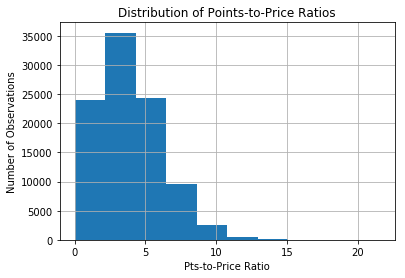

In [4]:
print('There are a total of {} unique prices over {} reviews.'
      .format(len(data['price'].unique()), data.shape[0]))

print('There are a total of {} unique ratings over {} reviews.'
      .format(len(data['points'].unique()), data.shape[0]))

#Create outcome variable
data['points-to-price'] = data['points'] / data['price']

#Plot histogram of outcome
plt.title('Distribution of Points-to-Price Ratios')
data['points-to-price'].hist()
####Labels####
plt.xlabel('Pts-to-Price Ratio')
plt.ylabel('Number of Observations')

## Straight Points-to-Price Model

__The Good News__

There is nothing too odd going on in the distribution of the results.We have one peak and 

__The Bad News__

Right skewed

## Clustering Reviews by Language

To get a better idea of the linguistics used in our wine reviews, we will use unsupervised clustering techniques to group similar reviews. We can use this information to determine if there are dramatic differences in review styles and which authors tend to write what styles. We may even pull out certain attributes associated with these styles.

There are several clustering techniques we could use, but the process by which we begin the process of modeling essentially begin the same; our linguistic observations (paragraphs, pages et al) are turned into vectors. One method of doing so is called the 'term-document matrix' (tdf). In tdf, stopwords such as 'the', 'is', 'and' et. al. are ignored, all other words are reduced to their lemmas (tasting => taste), and the presence-absense of each word (or the frequency therein) is encoded in a matrix in which each row represents a document, and each column represents a term.

As it goes, words that appear often (such as the word 'wine' in our wine reviews) are much less impactful than less common words. We therefore need to penalize words that occur too often by calculating the inverse document frequency.

In [5]:
#Split number
spl = int(0.2 * data.shape[0])

#Split data into training and test set
data_train = data[spl:]
data_test = data[:spl]

#Sanity Check
print(type(data['description']))
desc = data['description']

#We need to split our features seperately, as the vectorization process returns data in a different format
X = tfidf.fit_transform(desc)

#We can do this because the index carries over
X_train = X[spl:]
X_test = X[:spl]


########HIGHLIGHT#################
#You may be able to pull out some
#useful information here.
#
#Give commentary on this computation
#
#Show some common terms that came
#out of the description. (ie top
#n words)
#
#Result should be some displayed words.
##################################

print('Training set size: {}'.format(X_train.shape[0]))
print('Test set size: {}'.format(X_test.shape[0]))

#Set up our outcomes
Y_train, Y_test = data_train['points-to-price'], data_test['points-to-price']

#Lets explore our features
print('Number of linguistic features: {} {}'.format(X_train.shape[1], X_test.shape[1]))

#Most common terms
terms = tfidf.get_feature_names()

<class 'pandas.core.series.Series'>
Training set size: 77136
Test set size: 19284
Number of linguistic features: 17391 17391


In [8]:
#Find top n words

### Clustering

We will now be using the K-means clustering algorithm on our newly vectorized dataset. We will set our model to predict as many clusters as there are authors, this way we can see if there is significant differences in linguistics between authors.

We will be using the K-means clustering technique because we will be looking at the statistics of the syntax used by these authors, specifically, the inverse document frequency for every term. This gives us a nice normalized vector space to analyze. If in this vector space we are able to detect clusters of reviews, we can see how strongly the authorship of these reviews correlates to how the reviews cluster.

In [ ]:
#Initialize K-Means
km_taster = KMeans(n_clusters = len(data['taster_name'].unique()), init='k-means++', 
                   max_iter=100, n_init=1)

#Train model
km_taster.fit(X_train)

In [ ]:
#Category histogram
plt.title('K-Means Cluster Distribution')
plt.hist(km_taster.labels_)
plt.xlabel('Cluster Label')
plt.ylabel('n-clusters')

print('Number of labels: {}'.format(len(km_taster.labels_)))

In [ ]:
#Now we see how our algorithm clustered authorship.
cluster_results = pd.DataFrame(data_train['taster_name'])
cluster_results['cluster'] = km_taster.labels_

#Display first 10 results
dsp(cluster_results.head(10))

In [ ]:
tasters = cluster_results['taster_name'].unique()

print('Number of tasters: {}'.format(len(tasters)))

contingency_table = pd.crosstab(cluster_results['taster_name'],
                               cluster_results['cluster'], margins = True)

dsp(contingency_table)

#TODO: Contingency table visual representation

In [ ]:
#Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print('Chi-Squared Test Statistic: {}'.format(chi2))
print('P-Value: {}'.format(p))
print('Degrees of Freedom: {}'.format(dof))
#print('Expected: {}'.format(expected))

### Clustering Results

According to the statistical test, our clustering algorithm failed to highlight any correlation between authorship and syntax. This is good news for us as it allows us to explore correlations between our business goals and features the wineries have more control over.

### Content Analysis

It is time to dig in to the meat and potatos of this project. We now want to perform feature extraction on the bodies of text that constitute our reviews and perform correlative analysis between those features and our outcome variable. 

In [ ]:
#Perform feature reduction

#Instantiate model to reduce features to first 400
svd = TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy = False))

#Run SVD on training set and transform
X_train_lsa = lsa.fit_transform(X_train)

#Variance
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {}%".format(total_variance*100))

In [ ]:
#Instantiate and fit a machine learning algorithm
print(type(X_train_lsa))
print(X_train_lsa)
print(X_train_lsa.shape)

In [ ]:
#Explore model and find most impactful features.